In [1]:
include("Taylor.jl")
using TS

In [2]:
using PyPlot
using PyCall

In [3]:
function lorenz(t0::Real, tf::Real, x0::Real, y0::Real, z0::Real, r::Real, sigma::Real, b::Real, p::Int)
    # Inicializamos la lista de respuestas.
    tl = [t0]
    xl = [x0]
    yl = [y0]
    zl = [z0]
    
    # Ejecutamos mientras que el tiempo inicial sea menor al final.
    while t0 <= tf
        
        # Empezamos un Taylor con la condición inicial, un solo escalar.
        x = Taylor(x0)
        y = Taylor(y0)
        z = Taylor(z0)
        
        # A continuación se calcula la serie de Taylor hasta orden p
        # usando las relaciones de recurrencia entre f y x.
        for i in range(1,p)
           # En cada paso se vuelve a calcular la serie de Taylor de f(x),
           # cada vez a mayor orden.
            dx = sigma*(y-x)
            dy = r*x-y-x*z
            dz = x*y - b*z
           # De ésta se extrae el nuevo coeficiente de x(t) que se anexa.
            x = Taylor(push!(x.taylor_vec,dx.taylor_vec[i]/i))
            y = Taylor(push!(y.taylor_vec,dy.taylor_vec[i]/i))
            z = Taylor(push!(z.taylor_vec,dz.taylor_vec[i]/i))
        end
    
        # Ahora se escoge un paso. Como se recomienda, se toman los dos 
        # últimos términos de la serie para calcular h1 y h2.
        hx1 = (1/2)*(eps(1.0)/abs(x.taylor_vec[p+1]))^(1/p)
        hx2 = (1/2)*(eps(1.0)/abs(x.taylor_vec[p]))^(1/(p-1))
        hy1 = (1/2)*(eps(1.0)/abs(y.taylor_vec[p+1]))^(1/p)
        hy2 = (1/2)*(eps(1.0)/abs(y.taylor_vec[p]))^(1/(p-1))
        hz1 = (1/2)*(eps(1.0)/abs(z.taylor_vec[p+1]))^(1/p)
        hz2 = (1/2)*(eps(1.0)/abs(z.taylor_vec[p]))^(1/(p-1))
        # Luego se toma h como el mínimo de las anteriores h1 y h2 y se suma
        # al tiempo.
        h = minimum([hx1, hx2, hy1, hy2, hz1, hz2])
        t0 += h
    
        # Ahora sumamos la serie de acuerdo al método de Horner:
        sx = x.taylor_vec[p+1]
        sy = y.taylor_vec[p+1]
        sz = z.taylor_vec[p+1]
        for k in range(1,p)
            sx = x.taylor_vec[p+1-k] + h*sx
            sy = y.taylor_vec[p+1-k] + h*sy
            sz = z.taylor_vec[p+1-k] + h*sz
        end
    
        # x0 es ahora la suma de la serie: x(t0+h).
        x0 = sx
        y0 = sy
        z0 = sz
        
        # Vamos a poner una condición por si la solución diverge.
        if (isnan(x0) | (abs(x0) == Inf)) | (isnan(y0) | (abs(y0) == Inf)) | (isnan(z0) | (abs(z0) == Inf))
            println("La solución diverge en t = ", t0)
            println("No pude llegar al tiempo final t = ", tf)
            # Que devuelva las listas antes de la divergencia.
            return tl, xl, yl, zl
        end
        
        # Se anexa a la lista de respuestas.
        push!(tl,t0)
        push!(xl,x0)
        push!(yl,y0)
        push!(zl,z0)
    
    end
    # Se devuelven las lista.
    return tl, xl, yl, zl
end

lorenz (generic function with 1 method)

In [4]:
sigma = 10
b = 8/3

2.6666666666666665

In [5]:
t,x,y,z = lorenz(0.0,100,0.1,0.1,0.1,28,sigma,b,20);

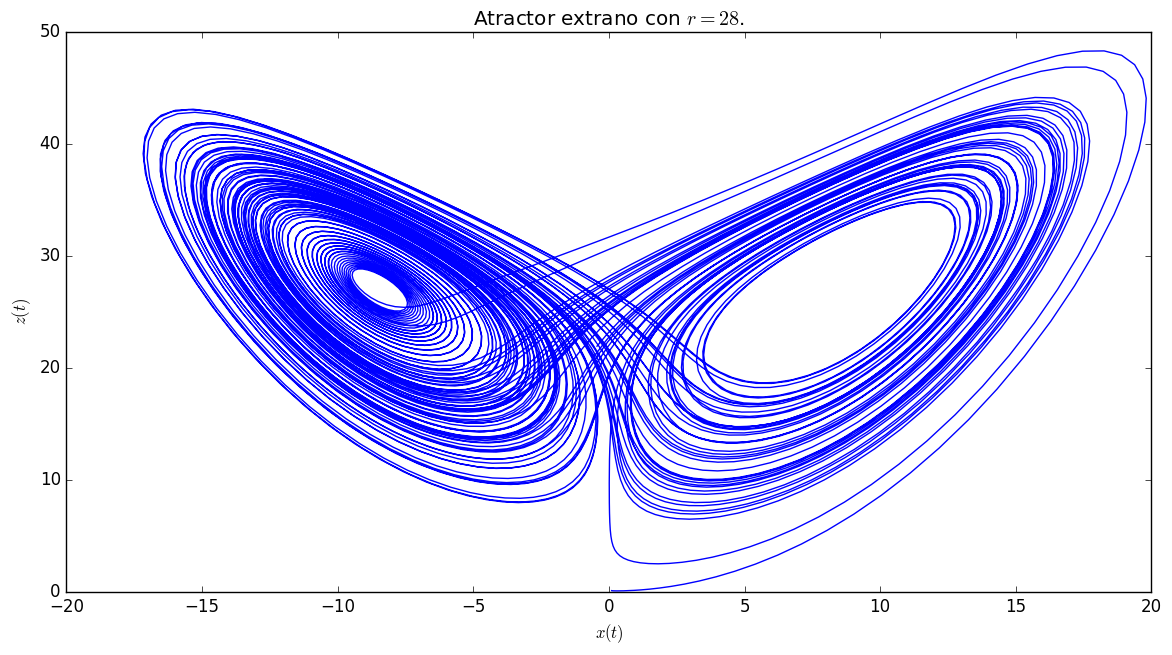

In [6]:
fig = figure("taylor_solution", figsize=(14,7))
pygui(false)
plot(x,z)
ylabel(L"$z(t)$")
xlabel(L"$x(t)$")
title(L"Atractor extrano con $r = 28$.")
show()

## Problema 9.3.2

$r = 10$

In [7]:
r = 10
t1,x1,y1,z1 = lorenz(0.0,100,0.1,0.1,0.1,r,sigma,b,20);

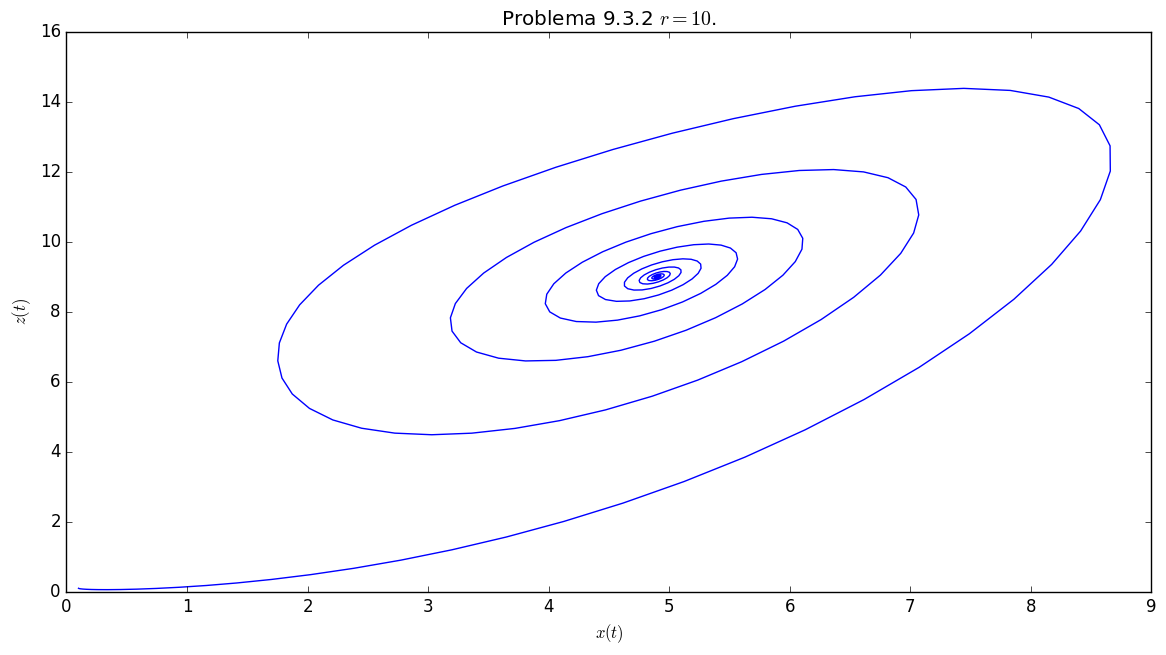

In [8]:
fig = figure("taylor_solution", figsize=(14,7))
plot(x1,z1)
ylabel(L"$z(t)$")
xlabel(L"$x(t)$")
title(L"Problema 9.3.2 $r = 10$.")
show()

Hacemos una animación para poderde mejor como se va formando la trayectoria.

In [9]:
@pyimport matplotlib.animation as anim 

In [10]:
# Función para abrir los videos en el notebook
function html_video(filename)
	base64_video = base64(open(readbytes, filename))
	"""<video controls src="data:video/x-m4v;base64,$base64_video">"""
end

html_video (generic function with 1 method)

In [15]:
pygui(true)
fig1 = figure()
ax = axes(xlim = (-20,20), ylim = (0,50))

global line1 = ax[:plot]([],[],"r-")[1]
global p1 = ax[:plot]([],[],"or")[1]

function init()
    global line1
    global p1
    line1[:set_data]([],[])
    p1[:set_data]([],[])
    return (line1,p1,Union{})
end

function animate(i)
    global line1
    global p1
    line1[:set_data](x[max(1,i+1-length(x)):i+1], z[max(1,i+1-length(x)):i+1])
    p1[:set_data]([x[i+1]],[z[i+1]])
    return (line1,p1,Union{})
end

myanim = anim.FuncAnimation(fig1, animate, init_func=init, frames=length(x),
        interval=20)


PyObject <matplotlib.animation.FuncAnimation object at 0x7fe0d2ab1150>

In [ ]:
myanim[:save]("lorenz1.mp4", bitrate=-1, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])

In [ ]:
display("text/html", html_video("lorenz1.mp4"))

## Problema 9.3.3

$r = 22$

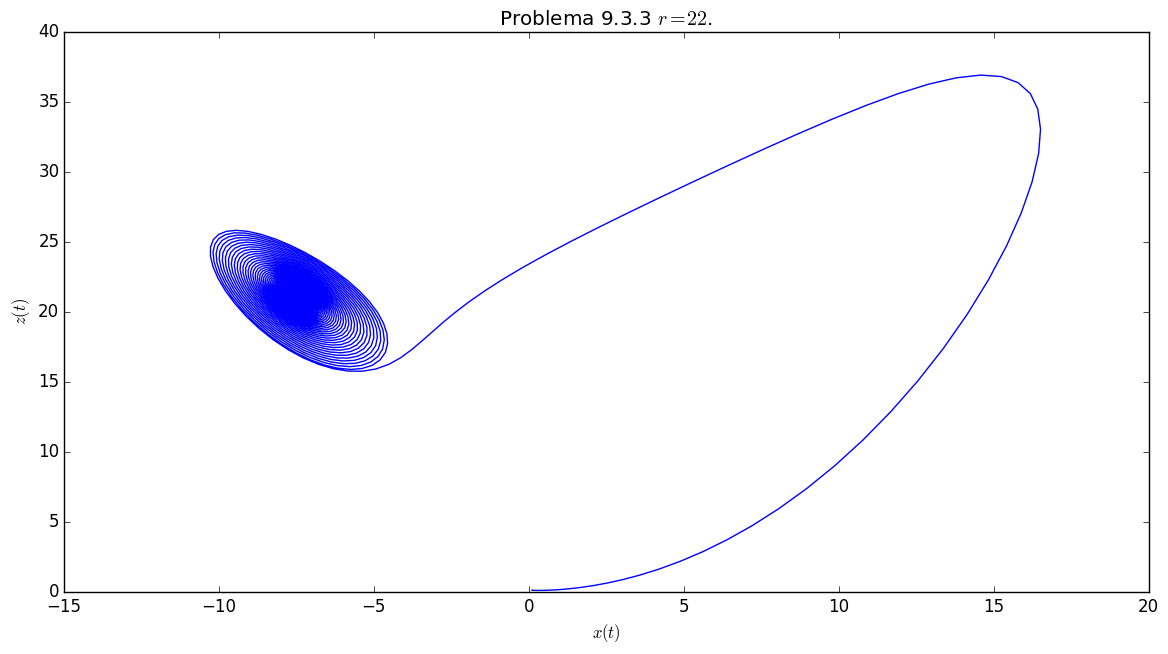

In [10]:
r = 22
t,x,y,z = lorenz(0.0,100,0.1,0.1,0.1,r,sigma,b,20)
fig = figure("taylor_solution", figsize=(14,7))
plt.plot(x,z);
plt.ylabel(L"$z(t)$");
plt.xlabel(L"$x(t)$");
plt.title(L"Problema 9.3.3 $r = 22$.");
show()

## Problema 9.3.4

$r = 24.5$

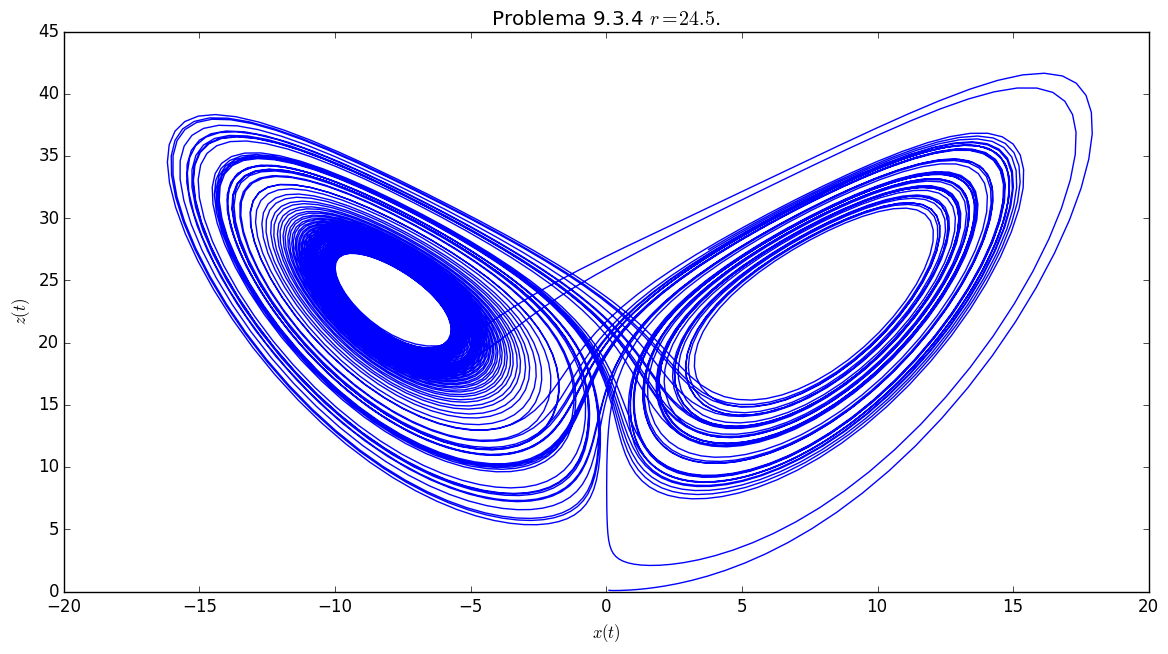

In [31]:
r = 24.5
t,x,y,z = lorenz(0.0,100,0.1,0.1,0.1,r,sigma,b,20)
fig = figure("taylor_solution", figsize=(14,7))
plt.plot(x,z);
plt.ylabel(L"$z(t)$");
plt.xlabel(L"$x(t)$");
plt.title(L"Problema 9.3.4 $r = 24.5$.");
show()

In [12]:
length(x)

2755

## Problema 9.3.5

$r = 100$

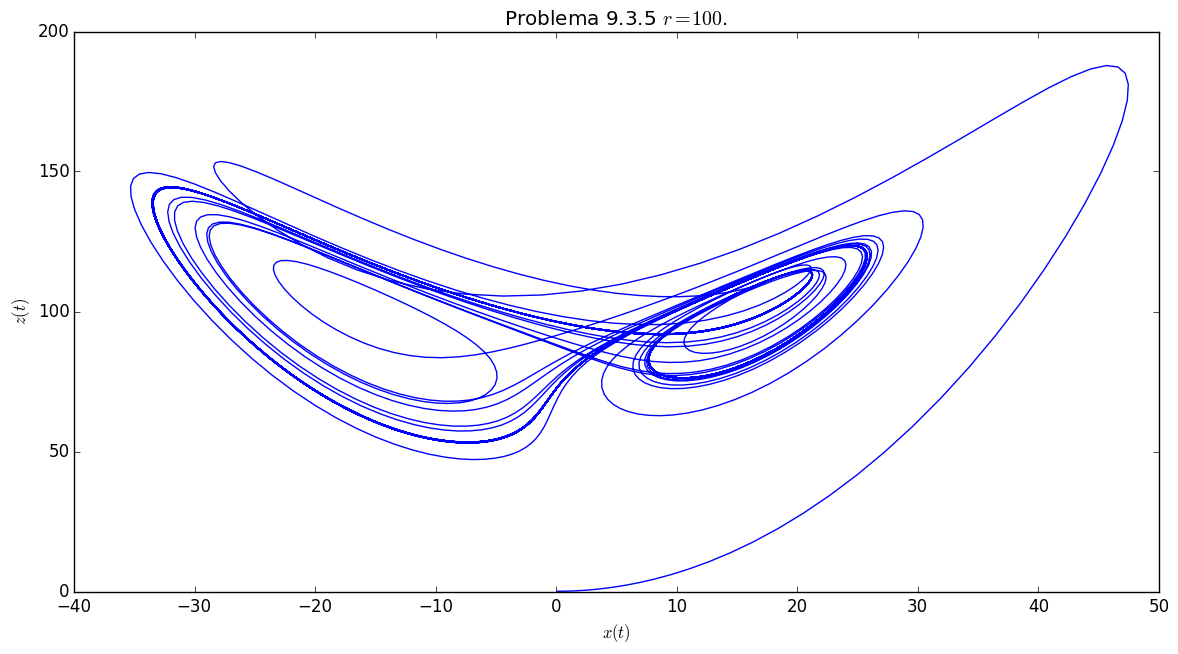

In [13]:
r = 100
t,x,y,z = lorenz(0.0,100,0.1,0.1,0.1,r,sigma,b,20)
fig = figure("taylor_solution", figsize=(14,7))
plt.plot(x,z);
plt.ylabel(L"$z(t)$");
plt.xlabel(L"$x(t)$");
plt.title(L"Problema 9.3.5 $r = 100$.");
show()

## Problema 9.3.6

$r = 126.52$

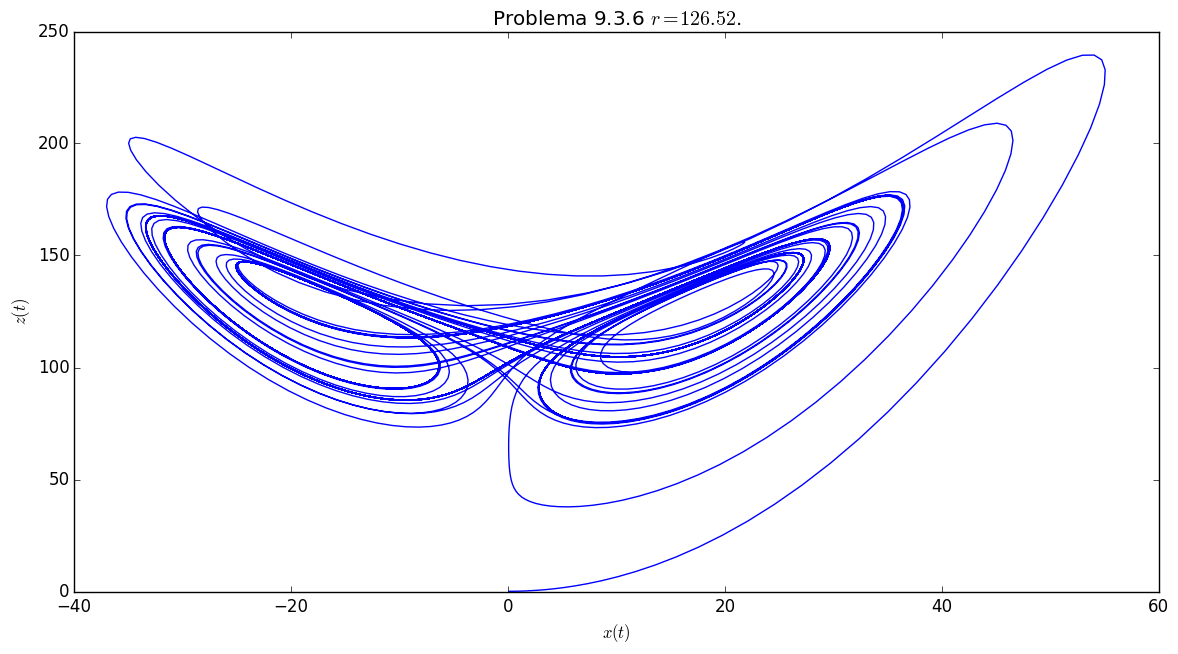

In [14]:
r = 126.52
t,x,y,z = lorenz(0.0,100,0.1,0.1,0.1,r,sigma,b,20)
fig = figure("taylor_solution", figsize=(14,7))
plt.plot(x,z);
plt.ylabel(L"$z(t)$");
plt.xlabel(L"$x(t)$");
plt.title(L"Problema 9.3.6 $r = 126.52$.");
show()

## Problema 9.3.7

$r = 400$

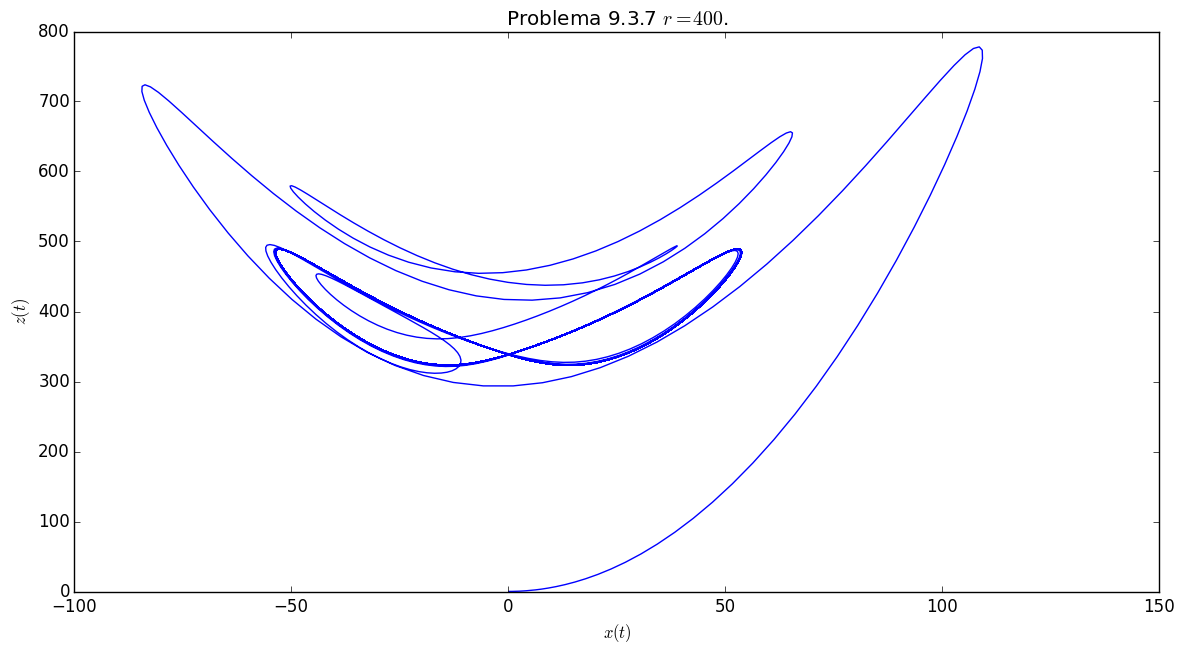

In [15]:
r = 400
t,x,y,z = lorenz(0.0,100,0.1,0.1,0.1,r,sigma,b,20)
fig = figure("taylor_solution", figsize=(14,7))
plt.plot(x,z);
plt.ylabel(L"$z(t)$");
plt.xlabel(L"$x(t)$");
plt.title(L"Problema 9.3.7 $r = 400$.");
show()

## Problema 9.3.9
$r = 28$

In [16]:
function diflorenz(t0::Real, tf::Real, x01::Real, y01::Real, z01::Real, x02::Real, y02::Real, z02::Real, r::Real, 
        sigma::Real, b::Real, p::Int)
    # Inicializamos la lista de respuestas.
    tl = [t0]
    x1l = [x01]
    y1l = [y01]
    z1l = [z01]
    x2l = [x02]
    y2l = [y02]
    z2l = [z02]
    
    # Ejecutamos mientras que el tiempo inicial sea menor al final.
    while t0 <= tf
        
        # Empezamos un Taylor con la condición inicial, un solo escalar.
        x1 = Taylor(x01)
        y1 = Taylor(y01)
        z1 = Taylor(z01)
        
        x2 = Taylor(x02)
        y2 = Taylor(y02)
        z2 = Taylor(z02)
        
        # A continuación se calcula la serie de Taylor hasta orden p
        # usando las relaciones de recurrencia entre f y x.
        for i in range(1,p)
           # En cada paso se vuelve a calcular la serie de Taylor de f(x),
           # cada vez a mayor orden.
            dx1 = sigma*(y1-x1)
            dy1 = r*x1-y1-x1*z1
            dz1 = x1*y1 - b*z1
            dx2 = sigma*(y2-x2)
            dy2 = r*x2-y2-x2*z2
            dz2 = x2*y2 - b*z2
           # De ésta se extrae el nuevo coeficiente de x(t) que se anexa.
            x1 = Taylor(push!(x1.taylor_vec,dx1.taylor_vec[i]/i))
            y1 = Taylor(push!(y1.taylor_vec,dy1.taylor_vec[i]/i))
            z1 = Taylor(push!(z1.taylor_vec,dz1.taylor_vec[i]/i))
            x2 = Taylor(push!(x2.taylor_vec,dx2.taylor_vec[i]/i))
            y2 = Taylor(push!(y2.taylor_vec,dy2.taylor_vec[i]/i))
            z2 = Taylor(push!(z2.taylor_vec,dz2.taylor_vec[i]/i))
        end
    
        # Ahora se escoge un paso. Como se recomienda, se toman los dos 
        # últimos términos de la serie para calcular h1 y h2.
        hx11 = (1/2)*(eps(1.0)/abs(x1.taylor_vec[p+1]))^(1/p)
        hx12 = (1/2)*(eps(1.0)/abs(x1.taylor_vec[p]))^(1/(p-1))
        hy11 = (1/2)*(eps(1.0)/abs(y1.taylor_vec[p+1]))^(1/p)
        hy12 = (1/2)*(eps(1.0)/abs(y1.taylor_vec[p]))^(1/(p-1))
        hz11 = (1/2)*(eps(1.0)/abs(z1.taylor_vec[p+1]))^(1/p)
        hz12 = (1/2)*(eps(1.0)/abs(z1.taylor_vec[p]))^(1/(p-1))
        hx21 = (1/2)*(eps(1.0)/abs(x2.taylor_vec[p+1]))^(1/p)
        hx22 = (1/2)*(eps(1.0)/abs(x2.taylor_vec[p]))^(1/(p-1))
        hy21 = (1/2)*(eps(1.0)/abs(y2.taylor_vec[p+1]))^(1/p)
        hy22 = (1/2)*(eps(1.0)/abs(y2.taylor_vec[p]))^(1/(p-1))
        hz21 = (1/2)*(eps(1.0)/abs(z2.taylor_vec[p+1]))^(1/p)
        hz22 = (1/2)*(eps(1.0)/abs(z2.taylor_vec[p]))^(1/(p-1))
        # Luego se toma h como el mínimo de las anteriores h1 y h2 y se suma
        # al tiempo.
        h = minimum([hx11, hx12, hy11, hy12, hz11, hz12, hx21, hx22, hy21, hy22, hz21, hz22])
        t0 += h
    
        # Ahora sumamos la serie de acuerdo al método de Horner:
        sx1 = x1.taylor_vec[p+1]
        sy1 = y1.taylor_vec[p+1]
        sz1 = z1.taylor_vec[p+1]
        sx2 = x2.taylor_vec[p+1]
        sy2 = y2.taylor_vec[p+1]
        sz2 = z2.taylor_vec[p+1]
        for k in range(1,p)
            sx1 = x1.taylor_vec[p+1-k] + h*sx1
            sy1 = y1.taylor_vec[p+1-k] + h*sy1
            sz1 = z1.taylor_vec[p+1-k] + h*sz1
            sx2 = x2.taylor_vec[p+1-k] + h*sx2
            sy2 = y2.taylor_vec[p+1-k] + h*sy2
            sz2 = z2.taylor_vec[p+1-k] + h*sz2
        end
    
        # x0 es ahora la suma de la serie: x(t0+h).
        x01 = sx1
        y01 = sy1
        z01 = sz1
        x02 = sx2
        y02 = sy2
        z02 = sz2
        
        # Vamos a poner una condición por si la solución diverge.
        if (isnan(x01) | (abs(x01) == Inf)) | (isnan(y01) | (abs(y01) == Inf)) | (isnan(z01) | (abs(z01) == Inf))
            println("La solución diverge en t = ", t0)
            println("No pude llegar al tiempo final t = ", tf)
            # Que devuelva las listas antes de la divergencia.
            return tl, x1l, y1l, z1l, x2l, y2l, z2l
        end
        
        if (isnan(x02) | (abs(x02) == Inf)) | (isnan(y02) | (abs(y02) == Inf)) | (isnan(z02) | (abs(z02) == Inf))
            println("La solución diverge en t = ", t0)
            println("No pude llegar al tiempo final t = ", tf)
            # Que devuelva las listas antes de la divergencia.
            return tl, x1l, y1l, z1l, x2l, y2l, z2l
        end
        
        # Se anexa a la lista de respuestas.
        push!(tl,t0)
        push!(x1l,x01)
        push!(y1l,y01)
        push!(z1l,z01)
        push!(x2l,x02)
        push!(y2l,y02)
        push!(z2l,z02)
    
    end
    # Se devuelven las lista.
    return tl, x1l, y1l, z1l, x2l, y2l, z2l
end

diflorenz (generic function with 1 method)

In [17]:
r = 28
t, x1, y1, z1, x2, y2, z2 = diflorenz(0.0,100,0.1,0.1,0.1,0.1+1.0e-15,0.1,0.1,r,sigma,b,20)

([0.0,0.0221874,0.0458849,0.0709158,0.0974093,0.124978,0.151921,0.177453,0.201523,0.223826  …  99.9031,99.9151,99.9267,99.9379,99.949,99.96,99.9707,99.9813,99.9918,100.002],[0.1,0.106181,0.125221,0.158928,0.211716,0.289992,0.396933,0.535707,0.711278,0.925179  …  -5.52056,-4.7296,-4.03317,-3.42515,-2.88987,-2.41506,-2.00548,-1.64833,-1.33398,-1.05463],[0.1,0.160321,0.231539,0.323069,0.448805,0.625478,0.861807,1.166,1.54956,2.01602  …  1.39508,1.571,1.65954,1.68814,1.67699,1.63955,1.58724,1.52735,1.46465,1.40235],[0.1,0.0945422,0.0892702,0.0844551,0.0805146,0.0783712,0.079547,0.0859328,0.100255,0.125952  …  31.6951,30.6099,29.5954,28.651,27.7601,26.9083,26.1123,25.3574,24.6318,23.9246],[0.1,0.106181,0.125221,0.158928,0.211716,0.289992,0.396933,0.535707,0.711278,0.925179  …  -11.5014,-12.1688,-12.7736,-13.2988,-13.7361,-14.0746,-14.2945,-14.3929,-14.3659,-14.2082],[0.1,0.160321,0.231539,0.323069,0.448805,0.625478,0.861807,1.166,1.54956,2.01602  …  -17.2056,-17.5894,-17.7374,-17.635,-17.27

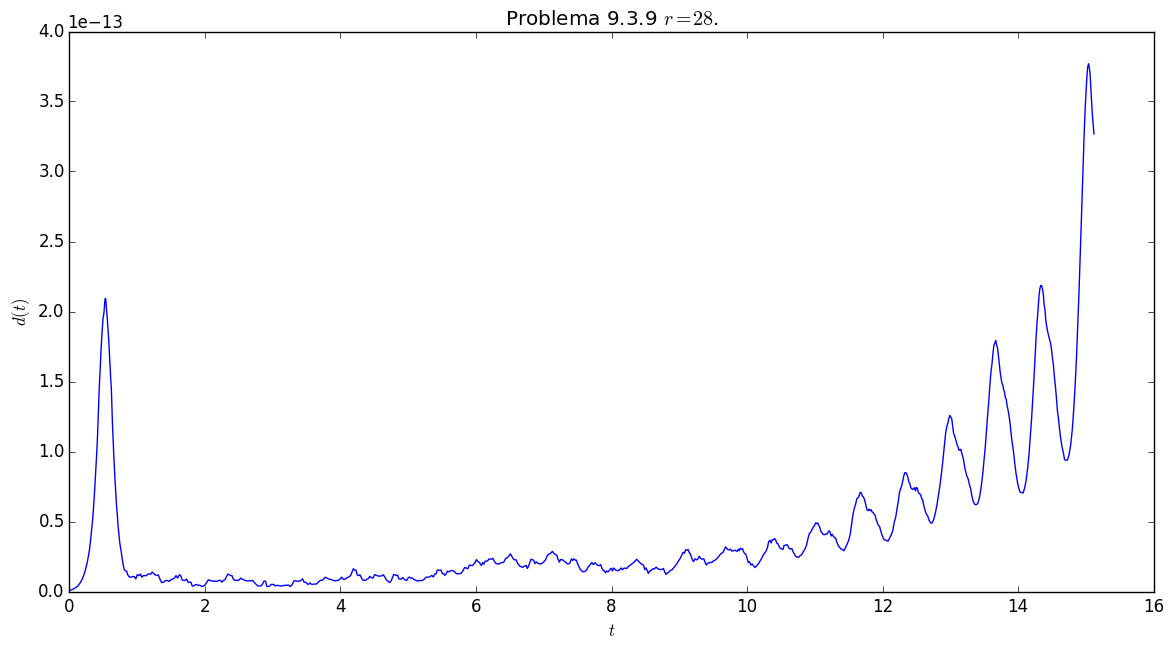

In [18]:
d = [sqrt((x1[i]-x2[i])^2 + (y1[i]-y2[i])^2 + (z1[i]-z2[i])^2) for i in range(1,length(x1))]

fig = figure("taylor_solution", figsize=(14,7))
plt.plot(t[1:800],d[1:800]);
plt.ylabel(L"$d(t)$");
plt.xlabel(L"$t$");
plt.title(L"Problema 9.3.9 $r = 28$.");
show()